# How does the CNN reacts to distorsions in the lower scales

Analysis with the ScatNet and the behavior on the dataset with varying AC showed that the model no longer sees PV panels and the the features leading to that are located in the low scales and are poorly transferable from one dataset to the other. 

Here, we verify this assumption by:
- Studying the correlation between the probability shift and the distance between the images
- See how the model responds by using the WCAM and see if a shift in the WCAM (interpreted as an inconsistency) is correlated with a shift in predicted probability

The shift in prob is what we observe from the model. The WCAM helps us understand whether it changed its behavior and the distance between images helps us establish whether there is something that actually changed. 

We use the Euclidean norm and the SSIM metrics to compute the image (dis)similarity. 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import os
from PIL import Image
import json
from src import utils
import torchvision
import pywt
from skimage.metrics import structural_similarity as ssim
import torch
from spectral_sobol.torch_explainer import WaveletSobol
import scipy
import cv2

2024-06-19 11:46:49.455441: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-19 11:46:53.331754: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# pick a bunch of images from the test set instances
# get the name of the test images, same accross Google and IGN
images_list=json.load(open('images_lists.json'))['test'] 

dataset_dir='path/to/bdappv/data'
n_samples=len(images_list)
print(n_samples)

np.random.seed(42)
images_subset=np.random.choice(images_list,n_samples)

# load the images
images_google=[
    Image.open(
        os.path.join(dataset_dir.format('google'),im_name) 
    ).convert('RGB') for im_name in images_subset
]

images_ign=[
    Image.open(
        os.path.join(dataset_dir.format('ign'),im_name) 
    ).convert('RGB') for im_name in images_subset
]

# rescale them
images_google=[
    torchvision.transforms.Resize(200)(im) for im in images_google
]
images_ign=[
    torchvision.transforms.CenterCrop(200)(im) for im in images_ign
]

4321


## Image and lower scale similarities

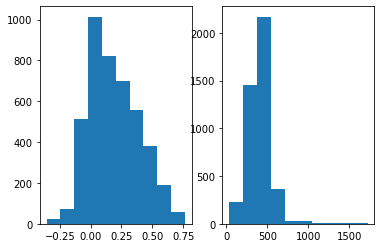

In [3]:
def get_approximation_coefficients(image, levels=3):
    """
    returns the approximation coefficients at the specified scale
    """
    if not isinstance(image,np.ndarray):
        image=np.array(image)

    input=image # take the approximation coefficients
                # of the latest level as the input
                # of the current level
    for _ in range(levels):
        i_A, (_, _, _)=pywt.dwt2(input, "haar")
        input=i_A
        
    approx=i_A # return the last approx coefficients

    return approx

def compute_similarity(im_a, im_b, metric="ssim"):
    """
    computes the similarity between two images
    """

    if not isinstance(im_a,np.ndarray):
        im_a=np.array(im_a)

    if not isinstance(im_b, np.ndarray):
        im_b=np.array(im_b)

    if metric=="euclidean":
        # Calculate squared difference between corresponding pixel values
        squared_diff = (im_a - im_b) ** 2

        # Compute the mean of squared differences
        mean_squared_diff = np.mean(squared_diff)

        # Take the square root to obtain the RMSE
        return np.sqrt(mean_squared_diff)
    
    elif metric=="ssim":
        return ssim(im_a, im_b, 
                    data_range=im_b.max() - im_b.min())
    
similarities={
    'ssim':[],
    'euclidean':[]
}

for im_a, im_b in zip(images_google, images_ign):

    im_a=im_a.convert('L')
    im_b=im_b.convert('L')

    # compute the approximation coefficients
    approx_a=get_approximation_coefficients(im_a)
    approx_b=get_approximation_coefficients(im_b)
    
    similarities['ssim'].append(
        compute_similarity(approx_a,approx_b,metric="ssim")
        #compute_similarity(im_a,im_b,metric="ssim")

    )
    similarities['euclidean'].append(
        compute_similarity(approx_a,approx_b,metric="euclidean")
        #compute_similarity(im_a,im_b,metric="euclidean")
    )

# plot the similarities between the images
fig, ax = plt.subplots(1,2)

ax[0].hist(similarities['ssim'])
ax[1].hist(similarities['euclidean'])
plt.show()

## Model predictions

In [4]:
# compute the predicted probabilities
BASELINE = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225)),
])

device='device'
model=torch.load('path/to/models').to(device)

x_ign=torch.stack([
    BASELINE(x) for x in images_ign
])

x_google=torch.stack([
    BASELINE(x) for x in images_google
])


def compute_probabilities(model, x, batch_size=256,label=1):
    """computes the predicted probabilities"""

    device=next(model.parameters()).device

    y=np.empty(x.shape[0])
    nb_batch=int(np.ceil(x.shape[0]/batch_size))

    with torch.no_grad():
        for batch_index in range(nb_batch):

            start_index=batch_index*batch_size
            end_index=min(
                x.shape[0], (batch_index+1)*batch_size
            )
            batch_x=x[start_index:end_index,:,:,:].to(device)
            batch_y=model(batch_x)
            # softmax the preds
            batch_y=torch.softmax(batch_y,dim=1)
            batch_y=batch_y[:,label].cpu().detach().numpy()
            y[start_index:end_index]=batch_y

    return y

ign_probs=compute_probabilities(model,x_ign)
google_probs=compute_probabilities(model,x_google)
delta_probs=np.abs(ign_probs-google_probs)

ssim
0.08427691195860754 0.25087297554456217
Correlation coefficient: -0.4097 (0.0000)


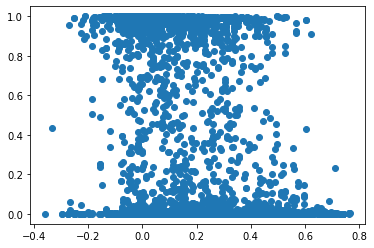

euclidean
460.51825147811337 381.54697001366253
Correlation coefficient: 0.2560 (0.0000)


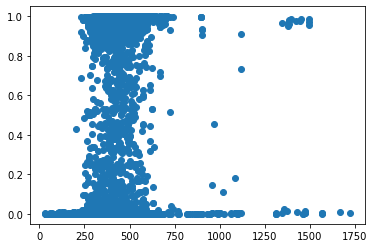

In [10]:
shift_index=np.argwhere(delta_probs>.5)
remaining_index=np.argwhere(delta_probs<=0.5)

for metric in ['ssim', "euclidean"]:


    print(metric)

    mean_shift=np.mean(np.array(similarities[metric])[shift_index])
    mean_stable=np.nanmean(np.array(similarities[metric])[remaining_index])

    r, pval=scipy.stats.mstats.pearsonr(similarities[metric], delta_probs)
   

    print(mean_shift,mean_stable)
    
    print(
        'Correlation coefficient: {:0.4f} ({:0.4f})'.format(r,pval)
    )

    plt.scatter(similarities[metric],delta_probs)
    plt.show()

Comment: images for which the probability shifts the most have a lower similarity than the images for which it does not change (on average). Shifts are very concentrated: either near 0 or near 1 (reflects the disappearance of a factor). SSIM of 0 indicates no similarity. 

## WCAM

We plot a set of WCAMs and compute for each of the predictions the (dis)similarity between them, according to two metrics: the scale consistency and the raw similarity (measured by the euclidean distance between the WCAMs). These metrics indicate how similar the scale decompositions are between the two images. We see how it correlates with the shift in prediction. 

In [6]:
# helpers

def rgb_to_wavelet_array(image, wavelet='haar', level=3):
    # Convert PIL image to NumPy array
    img_array = np.array(image.convert('L'))

    # Compute wavelet transform for each channel
    c = pywt.wavedec2(img_array, wavelet, level=level)     
    # normalize each coefficient array independently for better visibility
    c[0] /= np.abs(c[0]).max()
    for detail_level in range(level):
        c[detail_level + 1] = [d/np.abs(d).max() for d in c[detail_level + 1]]
    arr, _ = pywt.coeffs_to_array(c)

    
    return arr

def plot_wcam(ax, image, wcam, levels, vmin = None, vmax = None):
    """
    plts the wcam
    """

    def logplot(x):
        return np.log(1 + x)
    
    size = image.size[0]
    # compute the wavelet transform
    wt = rgb_to_wavelet_array(image,level = levels)
    
    # plots
    ax.imshow(wt, cmap = 'gray')

    vmin = logplot(vmin) if vmin is not None else vmin
    vmax = logplot(vmax) if vmax is not None else vmax

    #im = ax.imshow(1 + logplot(wcam), cmap = "hot", alpha = 0.5, vmin = vmin, vmax = vmax)

    minlog = np.min(logplot(wcam))
    im = ax.imshow(minlog  + logplot(wcam), cmap = "hot", alpha = 0.7, vmin = vmin, vmax = vmax)

    ax.axis('off')
    utils.add_lines(size, levels, ax)

    #cbar = plt.colorbar(im, ax = ax)
    #cbar.ax.tick_params(labelsize=10)

    return None

def compute_scale_embedding(wcam, levels=3, grid_size = 28):
    """
    computes the scale embedding of the prediction 
    from the wcam
    """
    scale_embedding = []

    # split the wcam to get the different scales
    # and compute the importance of each component
    # from the outermost to the innermost level
    for level in range(levels + 1):
        end, start = grid_size // (2 ** level), grid_size // (2 ** (level + 1))
        if start == 1:
            start = 0

        if level == levels: # approximation coefficient
            a = wcam[:end, end]
            scale_embedding.append(sum(a.flatten()))
        else:
            h = wcam[:start, start:end]
            v = wcam[start:end, :start]
            d = wcam[start:end, start:end]

            scale_embedding.append(sum(h.flatten()))
            scale_embedding.append(sum(v.flatten()))
            scale_embedding.append(sum(d.flatten()))


    # return the scale embedding
    scale_embedding = np.array(scale_embedding[::-1]) 
    scale_embedding /= sum(scale_embedding)

    return scale_embedding

### Quantitative evidence

In [14]:
grid_size=40

# pick the desired model 
wavelet = WaveletSobol(model, grid_size = grid_size, nb_design= 4, \
                       batch_size = 128, opt = {'size' : grid_size, "approximation": True})

wcams = {}

np.random.seed(42)
num_wcam=64
sample_indices=np.random.choice(n_samples,num_wcam)

subset_ign=[images_ign[k] for k in sample_indices]
subset_google=[images_google[k] for k in sample_indices]

# inputs to the wcam
x_ign=torch.stack([
    BASELINE(x) for x in subset_ign
])
y_ign=(ign_probs[sample_indices]>0.44).astype(int)

x_google=torch.stack([
    BASELINE(x) for x in subset_google
])
y_google=(google_probs[sample_indices]>0.44).astype(int)


wcams_ign=wavelet(x_ign,y_ign)
wcams_google=wavelet(x_google,y_google)

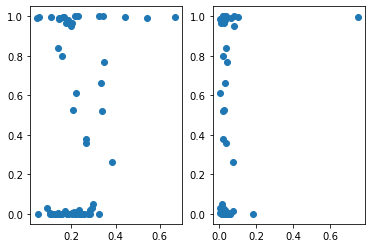

In [17]:
# store the embeddings in a matrix
# compute the rmses on the fly
levels=3
embeddings=np.zeros((num_wcam,1+levels*3,2))
wcams_distance=[]

for i in range(num_wcam):

    embeddings[i,:,0]=compute_scale_embedding(wcams_ign[i], grid_size=grid_size)
    embeddings[i,:,1]=compute_scale_embedding(wcams_google[i], grid_size=grid_size)

    wcams_distance.append(
        compute_similarity(wcams_ign[i], wcams_google[i], metric="euclidean")
    )

# get the delta prob corresponding to the selected 
# images
selected_probs=delta_probs[sample_indices]

# compute the distance between the embeddings
distance=np.linalg.norm(embeddings[:,:,0]-embeddings[:,:,1], axis=1)

fig, ax=plt.subplots(1,2)

ax[0].scatter(distance,selected_probs)
ax[1].scatter(wcams_distance,selected_probs)

In [18]:
# compute the correlation coefficient here between 
# the distance and the prob, and the wcams and the prob

for case, y in zip(["Scale embedding", "WCAM RMSE"], [distance,wcams_distance]):
    r, pval=scipy.stats.mstats.pearsonr(y, selected_probs)
    print(
        'Correlation coefficient: {:0.4f} ({:0.4f})'.format(r,pval)
    )

Correlation coefficient: 0.1803 (0.1540)
Correlation coefficient: 0.1658 (0.1903)


### Visualization

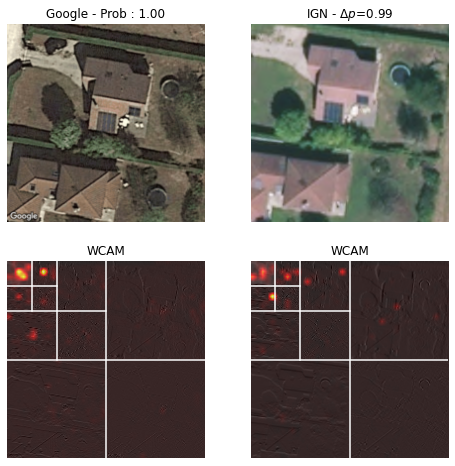

In [65]:
index=16


fig, ax=plt.subplots(2,2,figsize=(8,8))

ax[0,1].imshow(subset_ign[index])
ax[0,1].set_title('IGN - $\Delta p$={:0.2f}'.format(selected_probs[index]))
ax[0,0].imshow(subset_google[index])
ax[0,0].set_title('Google - Prob : {:0.2f}'.format(google_probs[sample_indices[index]]))

ax[0,0].axis('off')
ax[0,1].axis('off')

ax[1,0].set_title('WCAM')
ax[1,1].set_title('WCAM')

plot_wcam(ax[1,1], subset_ign[index], cv2.resize(wcams_ign[index], (200,200), interpolation=cv2.INTER_LINEAR), levels=3)
plot_wcam(ax[1,0], subset_google[index], cv2.resize(wcams_google[index], (200,200), interpolation=cv2.INTER_LINEAR), levels=3)

plt.savefig('example_delta_p_{}.pdf'.format(index))
plt.show()